## Insight on product categories
#### Sản phẩm được xác định duy nhất thông qua biến StockCode và mô tả ngắn Description. Mục đích của notebook để nhóm các sản phẩm vào các loại khác nhau
### I. Mô tả sản phẩm
#### 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
nltk.download('averaged_perceptron_tagger')
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nhocs\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()

    for s in dataframe[column]:
        if pd.isnull(s): continue
        # Convert all word to lower
        lines = s.lower()
        # tokenized word of lines
        tokenized = nltk.word_tokenize(lines)
        # pos_tag assigns to such as noun, verb, adjective, etc -> select noun
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t) # reduce word eg: cared --> care
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(column,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [3]:
df_init = pd.read_csv('../dataset/data_eda02.csv')
df_init

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
386932,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20
386933,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60
386934,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60
386935,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60


In [4]:
df_product = pd.DataFrame(df_init['Description'].unique()).rename(columns={0: 'Description'})

In [5]:
nltk.download('punkt')
keywords, keyword_roots, keywords_select, count_keywords = keywords_inventory(df_product)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nhocs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Nb of keywords in variable 'Description': 1462


##### keywords: Danh sách từ khóa được trích xuất
##### keywords_roots: Từ điển chứa khóa là các từ gốc và giá trị là danh sách các từ được infer từ từ gốc đó.
##### count_keywords: Từ điển liệt kê tần suất xuất hiện của các từ được sử dụng.

In [6]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

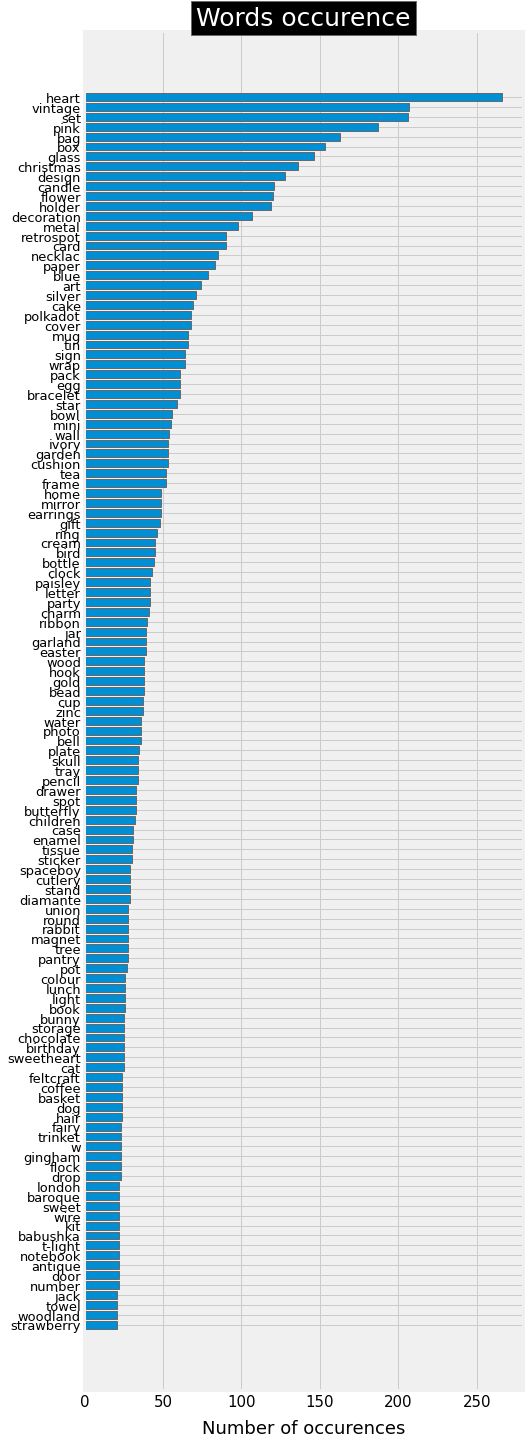

In [7]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### II. Xác định phân loại sản phẩm
- Loại bỏ các từ không có ý nghĩa và có tần suất nhỏ hơn 13 lần.

In [8]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Nb:', len(list_products))

Nb: 190


In [9]:
list_products

[['heart', 266],
 ['vintage', 207],
 ['set', 206],
 ['bag', 163],
 ['box', 153],
 ['glass', 146],
 ['christmas', 136],
 ['design', 128],
 ['candle', 121],
 ['flower', 120],
 ['holder', 119],
 ['decoration', 107],
 ['metal', 98],
 ['retrospot', 90],
 ['card', 90],
 ['necklac', 85],
 ['paper', 83],
 ['art', 74],
 ['silver', 71],
 ['cake', 69],
 ['polkadot', 68],
 ['cover', 68],
 ['mug', 66],
 ['tin', 66],
 ['sign', 64],
 ['wrap', 64],
 ['pack', 61],
 ['egg', 61],
 ['bracelet', 61],
 ['star', 59],
 ['bowl', 56],
 ['mini', 55],
 ['wall', 54],
 ['ivory', 53],
 ['garden', 53],
 ['cushion', 53],
 ['tea', 52],
 ['frame', 52],
 ['home', 49],
 ['mirror', 49],
 ['earrings', 49],
 ['gift', 48],
 ['ring', 46],
 ['cream', 45],
 ['bird', 45],
 ['bottle', 44],
 ['clock', 43],
 ['paisley', 42],
 ['letter', 42],
 ['party', 42],
 ['charm', 41],
 ['ribbon', 40],
 ['jar', 39],
 ['garland', 39],
 ['easter', 39],
 ['wood', 38],
 ['hook', 38],
 ['gold', 38],
 ['bead', 38],
 ['cup', 37],
 ['zinc', 37],
 ['wate

- Mã hóa dữ liệu
- Định nghĩa ma trận X với mỗi phần tử aij = 1 nếu mô tả sẩn phẩm i chứa từ j và bằng 0 trong TH ngược lại.

In [10]:
df_cleaned = df_init.copy(deep=True)
list_prod = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_prod))

In [11]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,flower,...,milk,funky,tidy,plant,diner,house,square,lace,wallet,point
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_prod):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [13]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       956                 
1<.<2       1006                
2<.<3       674                 
3<.<5       605                 
5<.<10      471                 
.>10        121                 


- Tạo các cụm của sản phẩm

In [14]:
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.09887768352057641
For n_clusters = 4 The average silhouette_score is : 0.12906940157083546
For n_clusters = 5 The average silhouette_score is : 0.15029176755736007
For n_clusters = 6 The average silhouette_score is : 0.10534050414335497
For n_clusters = 7 The average silhouette_score is : 0.1483219131844069
For n_clusters = 8 The average silhouette_score is : 0.15290011306095985
For n_clusters = 9 The average silhouette_score is : 0.15220593389781334


In [15]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.15029176755736007


Characterizing the content of clusters

In [16]:
pd.Series(clusters).value_counts()

1    1006
0     956
2     674
4     605
3     592
dtype: int64

In [17]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

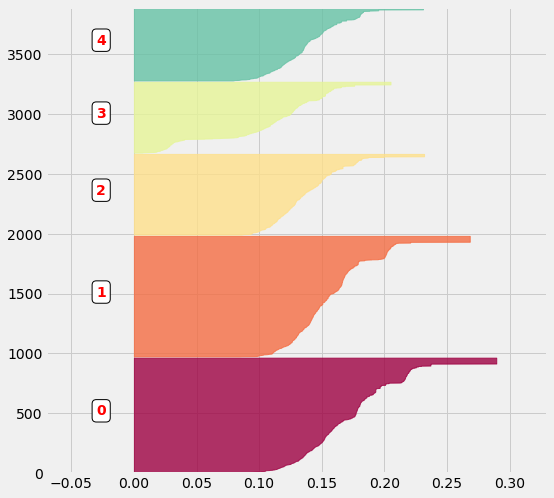

In [18]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

In [19]:
liste = pd.DataFrame(list_prod)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

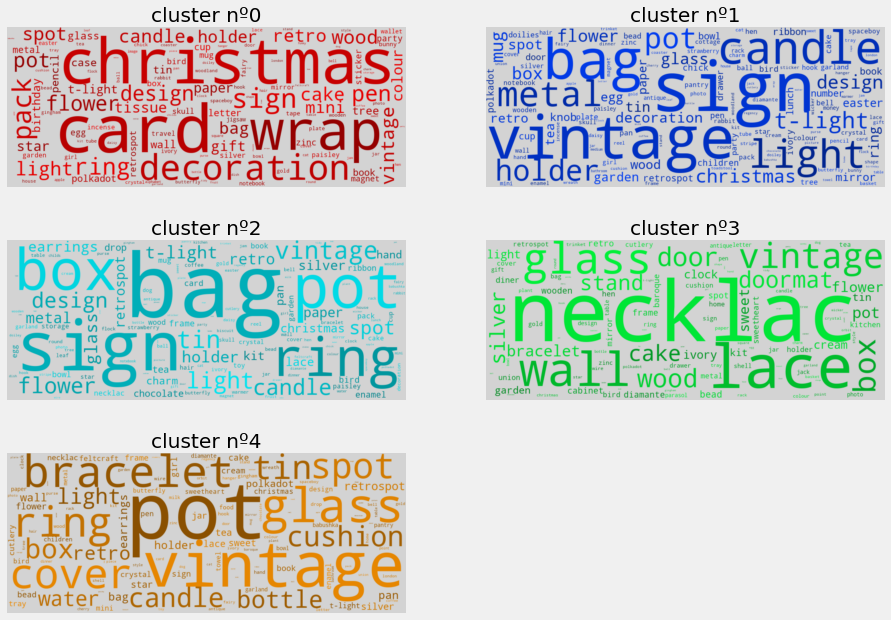

In [20]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

In [21]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

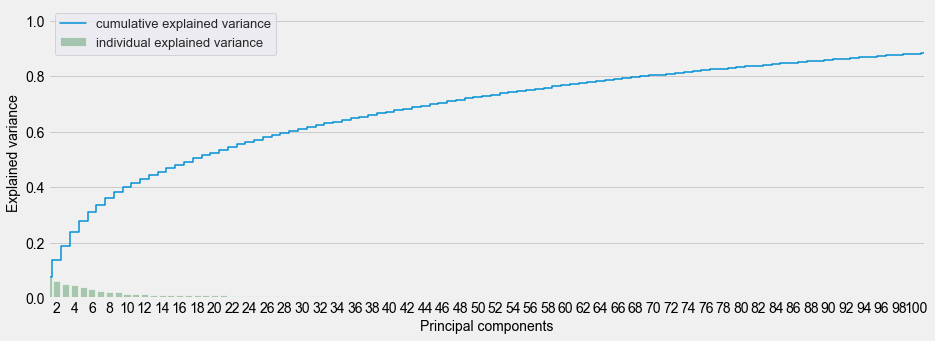

In [22]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

In [23]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

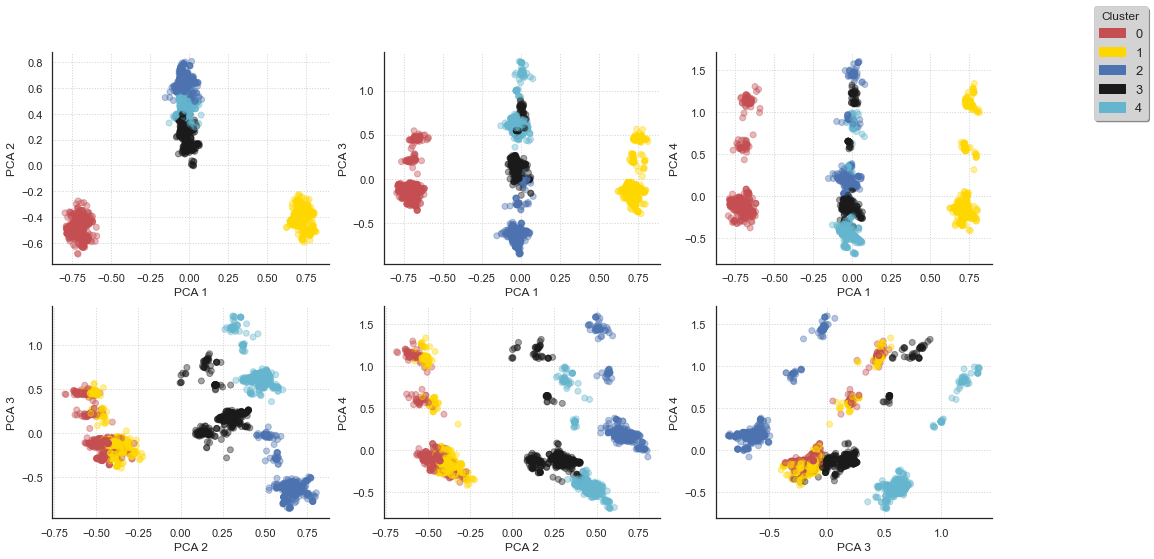

In [24]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

## Customer categories

In [25]:
clusters

array([2, 4, 4, ..., 0, 0, 2])

In [26]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34
...,...,...,...,...,...,...,...,...,...,...
386932,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20
386933,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60
386934,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60
386935,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60


In [27]:
corresp = dict()
for key, val in zip (list_prod, clusters):
    corresp[key] = val

df_cleaned['category_product'] = df_cleaned.loc[:, 'Description'].map(corresp)



### Group products

In [28]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['category_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

In [29]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,revenue,category_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,2,0.0,0.0,15.3,0.0,0.00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,4,0.0,0.0,0.0,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386932,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20,0,10.2,0.0,0.0,0.0,0.00
386933,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60,2,0.0,0.0,12.6,0.0,0.00
386934,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,4,0.0,0.0,0.0,0.0,16.60
386935,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,4,0.0,0.0,0.0,0.0,16.60


In [30]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])

In [32]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'BasketPrice'})

for i in range(5):
    column_name = f"categ_{i}"
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[column_name].sum()
    basket_price.loc[:, column_name] = temp

ValueError: Wrong number of items passed 3, placement implies 1

In [155]:
basket_price

,CustomerID,InvoiceNo,BasketPrice,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,537626,711.79,83.40,187.20,23.40,124.44,293.35
1,12347.0,542237,475.39,91.35,130.50,84.34,0.00,169.20
2,12347.0,549222,386.65,109.35,81.30,81.00,0.00,115.00
3,12347.0,556201,382.52,78.06,74.40,41.40,19.90,168.76
4,12347.0,562032,584.91,157.95,109.70,61.30,97.80,158.16
...,...,...,...,...,...,...,...,...
18035,18283.0,579673,220.31,106.21,74.70,29.65,0.00,9.75
18036,18283.0,580872,208.00,119.03,61.90,27.07,0.00,0.00
18037,18287.0,554065,765.28,134.70,540.90,40.68,34.00,15.00
18038,18287.0,570715,1001.32,326.04,386.44,256.84,0.00,32.00


In [156]:
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,revenue,category_product,categ_0,categ_1,categ_2,categ_3,categ_4,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,0,15.3,0.0,0.0,0.0,0.00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,4,0.0,0.0,0.0,0.0,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,4,0.0,0.0,0.0,0.0,20.34,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386932,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,10.20,2,0.0,0.0,10.2,0.0,0.00,10.20
386933,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,12.60,0,12.6,0.0,0.0,0.0,0.00,12.60
386934,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,4,0.0,0.0,0.0,0.0,16.60,16.60
386935,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,16.60,4,0.0,0.0,0.0,0.0,16.60,16.60


In [157]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

In [158]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

In [159]:
temp

,CustomerID,InvoiceNo,InvoiceDate_int
0,12347.0,537626,1291733820000001024
1,12347.0,542237,1296052199999999744
2,12347.0,549222,1302172979999999488
3,12347.0,556201,1307624460000000256
4,12347.0,562032,1312274880000000000
...,...,...,...
18035,18283.0,579673,1322657939999998720
18036,18283.0,580872,1323172920000001792
18037,18287.0,554065,1306060739999998976
18038,18287.0,570715,1318414979999998720


In [160]:
df_cleaned.drop('InvoiceDate_int', axis=1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['BasketPrice'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:10]

,CustomerID,InvoiceNo,BasketPrice,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12347.0,537626,711.79,83.40,187.2,23.40,124.44,293.35,2010-12-07 14:57:00.000001024
1,12347.0,542237,475.39,91.35,130.5,84.34,0.00,169.20,2011-01-26 14:29:59.999999744
2,12347.0,549222,386.65,109.35,81.3,81.00,0.00,115.00,2011-04-07 10:42:59.999999488
3,12347.0,556201,382.52,78.06,74.4,41.40,19.90,168.76,2011-06-09 13:01:00.000000256
4,12347.0,562032,584.91,157.95,109.7,61.30,97.80,158.16,2011-08-02 08:48:00.000000000
5,12347.0,573511,1294.32,512.40,203.3,154.30,55.60,368.72,2011-10-31 12:25:00.000001280
6,12347.0,581180,224.82,55.44,100.8,38.58,30.00,0.00,2011-12-07 15:52:00.000000000
7,12348.0,539318,652.80,0.00,174.0,478.80,0.00,0.00,2010-12-16 19:09:00.000000000
8,12348.0,541998,187.44,0.00,0.0,187.44,0.00,0.00,2011-01-25 10:42:00.000000000
9,12348.0,548955,327.00,0.00,310.0,17.00,0.00,0.00,2011-04-05 10:47:00.000000000


### Speration of data over time

In [161]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [162]:
set_train = basket_price[basket_price['InvoiceDate'] < pd.to_datetime("2011-1-10")]
set_test =  basket_price[basket_price['InvoiceDate'] >= pd.to_datetime("2011-1-10")]

basket_price = set_train.copy(deep=True)

### Consumer Order Combiations

In [163]:
transaction_per_user = basket_price.groupby(by=['CustomerID'])['BasketPrice'].agg(['count', 'min', 'max', 'mean', 'sum'])

In [164]:
transaction_per_user

,count,min,max,mean,sum
CustomerID,,,,,
12347.0,1,711.79,711.79,711.790,711.79
12348.0,1,652.80,652.80,652.800,652.80
12370.0,2,157.20,1587.07,872.135,1744.27
12377.0,1,1001.52,1001.52,1001.520,1001.52
12383.0,1,543.72,543.72,543.720,543.72
...,...,...,...,...,...
18245.0,1,365.73,365.73,365.730,365.73
18259.0,1,376.30,376.30,376.300,376.30
18260.0,2,230.70,538.82,384.760,769.52


In [165]:
for i in range(5):
    col = 'categ_{}'.format(i)
    transaction_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transaction_per_user['sum']*100

transaction_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transaction_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,1,711.79,711.79,711.790,711.79,11.716939,26.299892,3.287486,17.482684,41.212998
1,12348.0,1,652.80,652.80,652.800,652.80,0.000000,26.654412,73.345588,0.000000,0.000000
2,12370.0,2,157.20,1587.07,872.135,1744.27,32.999478,35.958883,9.958321,7.157722,13.925596
3,12377.0,1,1001.52,1001.52,1001.520,1001.52,21.926671,32.710280,9.837048,0.000000,35.526000
4,12383.0,1,543.72,543.72,543.720,543.72,3.255352,39.174575,48.852350,0.000000,8.717722


In [166]:
last_date = basket_price['InvoiceDate'].max().date()
first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

In [167]:
sub_first_registration = first_registration.applymap(lambda x: (last_date - x.date()).days)
sub_last_purchase = last_purchase.applymap(lambda x: (last_date - x.date()).days)

In [168]:
transaction_per_user.loc[:, 'LastPurchase']  = sub_last_purchase.reset_index(drop=False)['InvoiceDate']
transaction_per_user.loc[:, 'FirstPurchase'] = sub_first_registration.reset_index(drop=False)['InvoiceDate']

In [169]:
transaction_per_user

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,1,711.79,711.79,711.790,711.79,11.716939,26.299892,3.287486,17.482684,41.212998,33,33
1,12348.0,1,652.80,652.80,652.800,652.80,0.000000,26.654412,73.345588,0.000000,0.000000,24,24
2,12370.0,2,157.20,1587.07,872.135,1744.27,32.999478,35.958883,9.958321,7.157722,13.925596,23,26
3,12377.0,1,1001.52,1001.52,1001.520,1001.52,21.926671,32.710280,9.837048,0.000000,35.526000,20,20
4,12383.0,1,543.72,543.72,543.720,543.72,3.255352,39.174575,48.852350,0.000000,8.717722,18,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,18245.0,1,365.73,365.73,365.730,365.73,13.124436,33.549340,34.118065,0.000000,19.208159,21,21
959,18259.0,1,376.30,376.30,376.300,376.30,21.445655,13.393569,0.000000,0.000000,65.160776,32,32
960,18260.0,2,230.70,538.82,384.760,769.52,35.476661,30.798420,16.571369,11.344734,5.808816,0,24
961,18269.0,1,138.90,138.90,138.900,138.90,0.000000,28.509719,14.686825,0.000000,56.803456,32,32


## Creation of customer categories

In [170]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
selected_customers = transaction_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In [171]:
matrix

array([[1.00000000e+00, 7.11790000e+02, 7.11790000e+02, ...,
        3.28748648e+00, 1.74826845e+01, 4.12129982e+01],
       [1.00000000e+00, 6.52800000e+02, 6.52800000e+02, ...,
        7.33455882e+01, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e+00, 1.57200000e+02, 1.58707000e+03, ...,
        9.95832067e+00, 7.15772214e+00, 1.39255964e+01],
       ...,
       [2.00000000e+00, 2.30700000e+02, 5.38820000e+02, ...,
        1.65713692e+01, 1.13447344e+01, 5.80881589e+00],
       [1.00000000e+00, 1.38900000e+02, 1.38900000e+02, ...,
        1.46868251e+01, 0.00000000e+00, 5.68034557e+01],
       [1.00000000e+00, 1.08450000e+02, 1.08450000e+02, ...,
        7.74550484e+00, 5.48639926e+00, 1.51221761e+01]])

In [172]:
scaler_method = StandardScaler()
scaler_method.fit(matrix)

scaled_matrix = scaler_method.transform(matrix)

In [173]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

In [174]:
pca_samples

array([[ 1.81511029e+00, -1.82248276e-01, -1.22022584e+00, ...,
        -3.69669346e-01,  2.32008509e-02, -1.17542016e-03],
       [ 1.50878626e+00,  3.69614150e+00, -2.88611055e-01, ...,
        -1.68350520e-01,  1.21877488e-02, -8.89922452e-04],
       [ 2.24764914e+00,  3.12934736e-01,  4.54050765e-01, ...,
         1.93176040e+00, -2.33696006e-01, -1.56848633e-03],
       ...,
       [ 1.92784343e-01,  5.86991851e-01,  7.15138927e-01, ...,
         2.57974989e-01, -5.41011378e-02, -9.66127392e-04],
       [-9.74260395e-01,  5.69036706e-01, -1.70849863e+00, ...,
         5.25483181e-02,  2.03639071e-02, -1.72521376e-03],
       [-1.07303523e+00,  3.41674233e-01,  7.71157756e-01, ...,
         4.09525619e-02,  9.57661923e-03, -7.97124168e-04]])

In [175]:
import numpy as np 

def save_file(data, file_name):
    with open(file_name, 'wb') as file:
        np.save(file, data)        

In [176]:
folder_save = '../dataset'
save_file(scaled_matrix, f"{folder_save}/scald_matrix.npy")
save_file(pca_samples, f"{folder_save}/pca_samples.npy")